In [1]:
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [86]:
% load_ext autoreload
% autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import numpy as np
import pandas as pd
from pandas.core.dtypes.common import is_string_dtype,is_numeric_dtype
from sklearn.model_selection import train_test_split,KFold,ParameterGrid
from sklearn.ensemble import RandomForestRegressor,forest
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tqdm._tqdm_notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from imp_functions import *
from pathlib import Path
from collections import OrderedDict
warnings.filterwarnings('ignore')

## Loading dataset

In [4]:
PATH = Path('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge')
list(PATH.iterdir())

[PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.200d.txt'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.zip'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/train.tsv'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/test.tsv'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.100d.txt'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.300d.txt'),
 PosixPath('/data/ssubrahmannian/.kaggle/competitions/mercari-price-suggestion-challenge/glove.6B.50d.txt')]

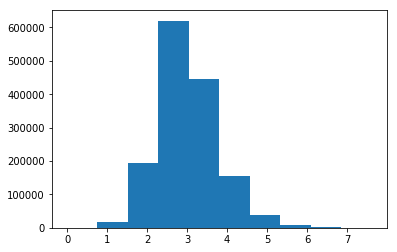

In [5]:
train_df = pd.read_csv(PATH/'train.tsv',sep = '\t')
train_df.price = np.log1p(train_df.price)
plt.hist(train_df.price)
plt.show()

In [123]:
# One of the most important idea is to split the dataset into train,validation,test
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['price','train_id'],axis=1), train_df['price'], test_size=0.2, random_state=42)

## Simple model 1

In [41]:
X_train.dtypes

name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
item_description     object
dtype: object

In [21]:
initial_params = {'max_features': 'sqrt',
                  'min_samples_leaf': 1,
                  'n_estimators': 200,
                  'n_jobs': -1,
                  'random_state': 42}

In [22]:
X_train = X_train.loc[:,['item_condition_id','category_name','brand_name','shipping']]
X_test = X_test.loc[:,['item_condition_id','category_name','brand_name','shipping']]

In [14]:
grid = {
    'min_samples_leaf': [5],
    'max_features': ['sqrt',1],
    'n_estimators': [50],
    'n_jobs': [-1],
    'random_state': [42]
}
train = pd.concat([X_train,y_train],axis=1)
cols =[]
scores = perform_regularised_cv(train_df,'price',grid,cols,metric=mean_squared_error)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:20<02:20, 140.27s/it]

100%|██████████| 2/2 [04:16<00:00, 128.17s/it]



In [15]:
pd.DataFrame(scores).sort_values(by=1).loc[:10,:]

,0,1
0,"{'max_features': 'sqrt', 'min_samples_leaf': 5...",0.405613
1,"{'max_features': 1, 'min_samples_leaf': 5, 'n_...",0.433721


In [16]:
best_params = pd.DataFrame(scores).sort_values(by=1)
best_params.reset_index(drop=True,inplace=False)
best_parameters = best_params.iloc[0,0]
best_parameters 

{'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 50,
 'n_jobs': -1,
 'random_state': 42}

In [9]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [27]:
final_model,_,train,test = train_model(best_parameters,train,test,'price',cols,valid=True,metric = mean_squared_error)
final_predictions = final_model.predict(test.drop('price',axis=1))

In [30]:
np.sqrt(mean_squared_error(y_test,final_predictions))

0.5589925383503703

## Model 2

In [67]:
## Collecting all features into one df
# One of the most important idea is to split the dataset into train,validation,test
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['price','train_id'],axis=1), train_df['price'], test_size=0.2, random_state=42)
doc2topic = pd.read_feather('/data/ssubrahmannian/data/doc2topic.feather')
doc_matric = pd.read_feather('/data/ssubrahmannian/data/doc_matric.feather')
X_train['train'] =1
X_test['train'] =0
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
df = X_train.append(X_test,ignore_index=True)
df = pd.concat([df,doc_matric],axis=1)
df = pd.concat([df,doc2topic],axis=1)

In [68]:
X_train = df[df['train']==1]
X_train.drop('item_description',axis=1,inplace=True)
X_test = df[df['train']==0]
X_test.drop('item_description',axis=1,inplace=True)
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

In [69]:
initial_params = {'max_features': 'sqrt',
                  'min_samples_leaf': 5,
                  'n_estimators': 200,
                  'n_jobs': -1,
                  'random_state': 42}
cols =[]
X_train.loc[:,'price'] = y_train.values
X_test.loc[:,'price'] = y_test.values

In [182]:
n_est_model,scores,train,test = train_model(initial_params,X_train,X_test,'price',cols,valid=True,metric = mean_squared_error)

Category encoding
Apply mean encoding on train dataset


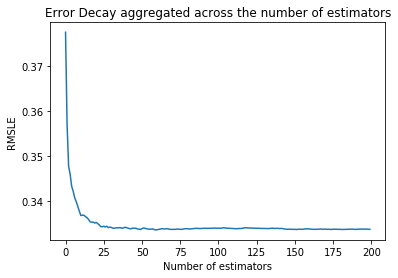

In [187]:
n_estim_calculate(n_est_model,train)

In [10]:
n_est_selected = 75

In [11]:
grid = {
    'min_samples_leaf': [5,10],
    'max_features': ['sqrt', 'log2', 'auto', 0.5],
    'n_estimators': [n_est_selected],
    'n_jobs': [-1],
    'random_state': [42]
}
cols =[]
scores = perform_regularised_cv(X_train,'price',grid,cols,metric=mean_squared_error)

Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.58360212242649
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.5886287397026663
Parameters: {'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.5966342691182834
Parameters: {'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.6036538596507788
Parameters: {'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.5632625726021769
Parameters: {'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.561781713524313
Parameters: {'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} RMSLE: 0.5610026750783095
Parameters: {'max_featu

In [12]:
final_params = {'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} 
final_model,scores,train,test = train_model(final_params,X_train,X_test,'price',cols,valid=True,metric = mean_squared_error)

In [13]:
final_score = np.sqrt(scores)
final_score

0.5596575873375578

In [14]:
fi = feature_importance(train,final_model)
fi

,cols,importance
0,brand_name,0.149390
1,category_name,0.118425
2,name,0.114913
3,shipping,0.070042
4,item_condition_id,0.045041
5,lularoe,0.036012
6,Topic3,0.032404
7,Automated_topic_id,0.029337
8,Topic12,0.028384
9,Topic4,0.024715


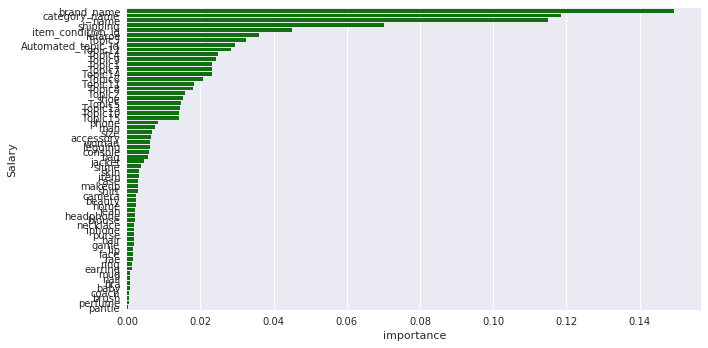

In [16]:
plot_feature_importance(fi[fi['importance']>0])

In [21]:
to_keep = fi[fi['importance']>0].loc[:,'cols'].tolist()+['price']

In [22]:
X_train_keep = X_train.loc[:,to_keep]
X_test_keep = X_test.loc[:,to_keep]

In [23]:
final_params = {'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 75, 'n_jobs': -1, 'random_state': 42} 
final_model,scores,train,test = train_model(final_params,X_train_keep,X_test_keep,'price',cols,valid=True,metric = mean_squared_error)

In [24]:
final_score = np.sqrt(scores)
final_score

0.5594596123516037

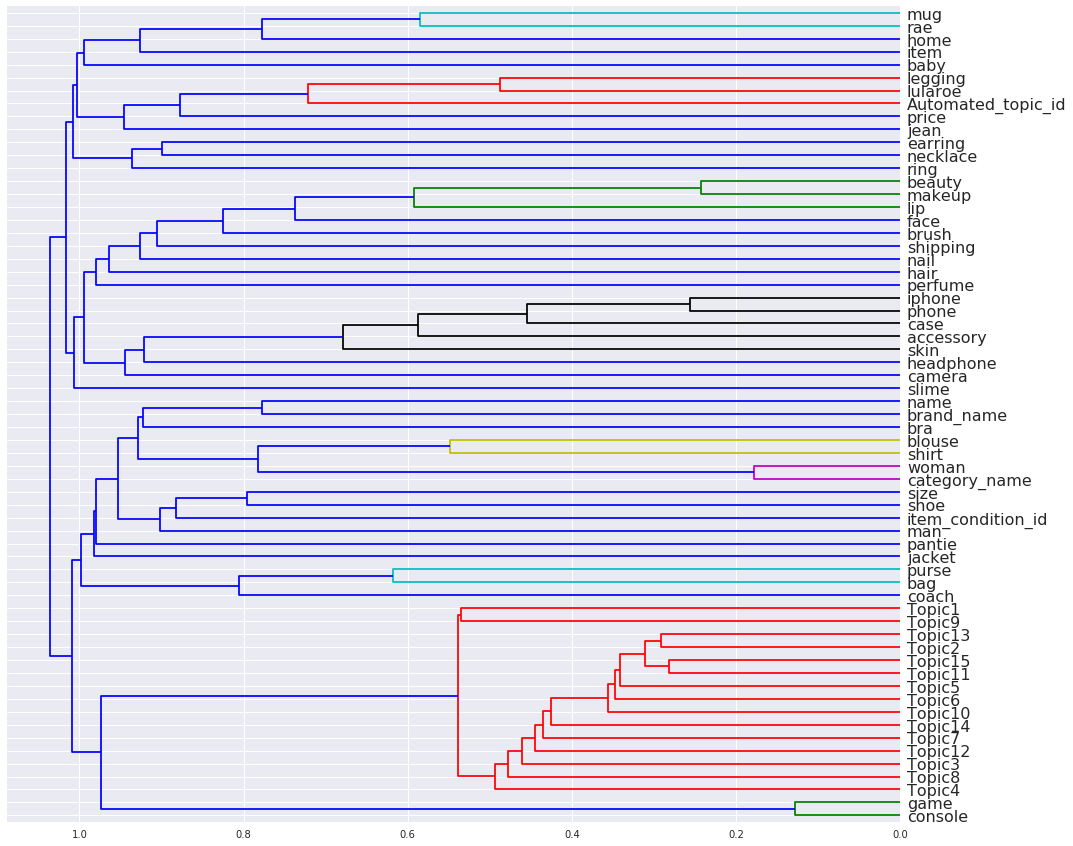

In [27]:
dendrogram(train)

In [28]:
fi = feature_importance(train,final_model)
fi

,cols,importance
0,brand_name,0.150245
1,category_name,0.119882
2,name,0.113930
3,shipping,0.071115
4,item_condition_id,0.044800
5,lularoe,0.034374
6,Topic3,0.030698
7,Automated_topic_id,0.030408
8,Topic12,0.027319
9,Topic4,0.024708


In [29]:
X_train_keep.shape

(1186028, 63)

In [44]:
set_rf_samples(40000)

sfs1 = sfs(final_model, 
           k_features=25, 
           forward=False, 
           floating=True, 
           scoring='neg_mean_squared_error',
           cv=5,
           verbose=2,
           n_jobs=-1)

sfs2 = sfs1.fit(X_train_keep.drop('price',axis=1).values, y_train.values)


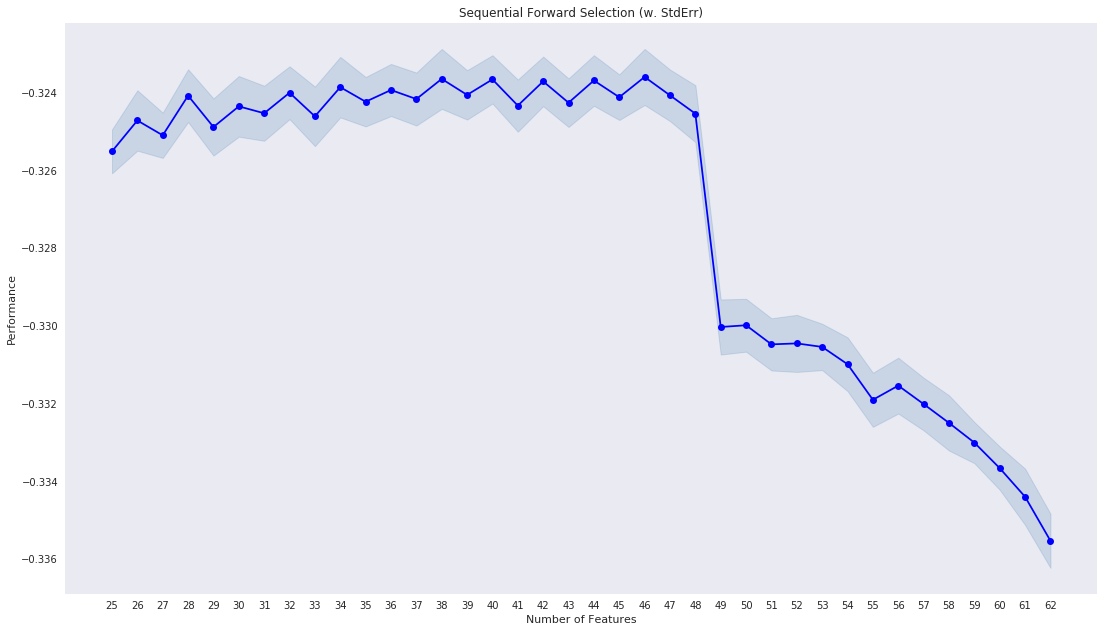

In [54]:

fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [56]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
62,-0.335524,0.00178909,"[-0.3338472033389511, -0.3359987417646649, -0....","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.00139197,0.000695987
61,-0.334392,0.00185866,"[-0.33282859222760347, -0.33547417457509493, -...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...",0.0014461,0.00072305
60,-0.333656,0.00142797,"[-0.33244322823173045, -0.3339535582615818, -0...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15,...",0.00111101,0.000555503
59,-0.332999,0.00135912,"[-0.3323346550976872, -0.33298884970089143, -0...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15,...",0.00105744,0.00052872
58,-0.332492,0.00182497,"[-0.33117539603012763, -0.3326980333796481, -0...","(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 17...",0.00141989,0.000709945
57,-0.332007,0.00173973,"[-0.3303559311045222, -0.33218110816366675, -0...","(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 18...",0.00135357,0.000676786
56,-0.331533,0.00184522,"[-0.33014374461650975, -0.33163321897968634, -...","(0, 1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 18, 1...",0.00143565,0.000717823
55,-0.331897,0.00178708,"[-0.3309098748082116, -0.3324080480705485, -0....","(0, 1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 18, 1...",0.00139041,0.000695204
54,-0.330983,0.00177654,"[-0.32950930090989655, -0.3310484639682964, -0...","(0, 1, 2, 3, 4, 5, 6, 9, 13, 14, 15, 18, 19, 2...",0.00138221,0.000691104
53,-0.330537,0.00153101,"[-0.32930406640755205, -0.330536172980059, -0....","(0, 1, 2, 3, 4, 5, 6, 9, 13, 14, 15, 18, 20, 2...",0.00119118,0.000595591


In [61]:
list(sfs2.k_feature_idx_)

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 18,
 23,
 24,
 25,
 26,
 27,
 30,
 31,
 32,
 34,
 35,
 39,
 40,
 47,
 49,
 51,
 55,
 56]

In [159]:
to_keep_final = list(sfs2.k_feature_idx_)

In [161]:
X_train_keep.columns[to_keep_final]

Index(['brand_name', 'category_name', 'name', 'shipping', 'item_condition_id',
       'lularoe', 'Automated_topic_id', 'shoe', 'phone', 'man', 'size',
       'accessory', 'woman', 'bag', 'jacket', 'slime', 'item', 'case',
       'beauty', 'home', 'hair', 'lip', 'rae', 'nail', 'bra'],
      dtype='object')

In [162]:
to_keep_final = ['brand_name', 'category_name', 'name', 'shipping', 'item_condition_id',
       'lularoe', 'Automated_topic_id', 'shoe', 'phone', 'man', 'size',
       'accessory', 'woman', 'bag', 'jacket', 'slime', 'item', 'case',
       'beauty', 'home', 'hair', 'lip', 'rae', 'nail', 'bra']

## XGBoost

In [70]:
X_train.head()


,name,item_condition_id,category_name,brand_name,shipping,train,legging,lularoe,beauty,hair,...,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Automated_topic_id,price
0,LuLaRoe kids L/XL leggings,3,Kids/Boys (4+)/Bottoms,NaN,1,1,1,1,0,0,...,0.007407,0.501326,0.007407,0.007407,0.007407,0.007407,0.007407,0.007407,Topic9,2.772589
1,Bundle 5 Display mannequins,1,Other/Other/Other,NaN,0,1,0,0,0,0,...,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,Topic14,3.806662
2,LIVING PROOF PERFECT HAIR DAY DRY SHAMPO,1,Beauty/Hair Care/Styling Products,NaN,0,1,0,0,1,3,...,0.875271,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,0.001481,Topic8,3.583519
3,Palazzo pants,2,Women/Pants/Casual Pants,NaN,0,1,0,0,0,0,...,0.001667,0.455888,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,Topic5,2.995732
4,RESERVED FOR Ms Jas PINK BOYSHORTS LARGE,1,Women/Underwear/Panties,PINK,1,1,0,0,0,0,...,0.006667,0.006667,0.797322,0.116012,0.006667,0.006667,0.006667,0.006667,Topic10,3.433987


In [83]:
X_train.dtypes

name                   object
item_condition_id       int64
category_name          object
brand_name             object
shipping                int64
train                   int64
legging                 int64
lularoe                 int64
beauty                  int64
hair                    int64
size                    int64
item                    int64
woman                   int64
pantie                  int64
woman_underwear         int64
beauty_makeup           int64
lip                     int64
man                     int64
accessory               int64
necklace                int64
perfume                 int64
woman_jewelry           int64
apparel_pant            int64
tight_legging           int64
woman_athletic          int64
home_décor              int64
home                    int64
home_kitchen            int64
rae                     int64
kid_toy                 int64
                       ...   
bag                     int64
ring                    int64
beauty_ski

In [91]:
train.isnull().sum()

name                  236947
item_condition_id     236947
category_name         242030
brand_name            743005
shipping              236947
train                 236947
legging               236947
lularoe               236947
beauty                236947
hair                  236947
size                  236947
item                  236947
woman                 236947
pantie                236947
woman_underwear       236947
beauty_makeup         236947
lip                   236947
man                   236947
accessory             236947
necklace              236947
perfume               236947
woman_jewelry         236947
apparel_pant          236947
tight_legging         236947
woman_athletic        236947
home_décor            236947
home                  236947
home_kitchen          236947
rae                   236947
kid_toy               236947
                       ...  
ring                  236947
beauty_skin           236947
care_face             236947
camera        

In [177]:
grid = {'max_depth': [10, 15, 20, 25],
          'subsample': [0.8],
          'colsample_bytree': [0.5,0.7, 0.9],
          'learning_rate': [0.01, 0.1, 0.2,0.4],
          'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100],
          'n_estimators': [ 60,80,100,120],
          'silent': [False],
          'min_child_weight': [1],
          'objective': ['reg:linear'],
          'eval_metric': ['rmse'],
          'seed': [42],
          'n_jobs': [-1]}
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['price','train_id'],axis=1), train_df['price'], test_size=0.2, random_state=42)
doc2topic = pd.read_feather('/data/ssubrahmannian/data/doc2topic.feather')
doc_matric = pd.read_feather('/data/ssubrahmannian/data/doc_matric.feather')
X_train['train'] =1
X_test['train'] =0
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
df = X_train.append(X_test,ignore_index=True)
df = pd.concat([df,doc_matric],axis=1)
df = pd.concat([df,doc2topic],axis=1)
X_train = df[df['train']==1]
X_train.drop('item_description',axis=1,inplace=True)
X_test = df[df['train']==0]
X_test.drop('item_description',axis=1,inplace=True)
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

In [178]:
X_train = X_train.loc[:,to_keep_final]
X_test = X_test.loc[:,to_keep_final]

In [179]:
X_train.loc[:,'price'] = y_train.values
X_test.loc[:,'price'] = y_test.values

In [ ]:
cols =['name','item_condition_id',
       'category_name','brand_name']
scores = perform_regularised_cv(X_train,'price',grid,cols,folds=5,metric=mean_squared_error,model='XGBoost')

Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 60, 'n_jobs': -1, 'objective': 'reg:linear', 'reg_alpha': 1e-05, 'seed': 42, 'silent': False, 'subsample': 0.8} RMSLE: 1.5073191653212763
Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 60, 'n_jobs': -1, 'objective': 'reg:linear', 'reg_alpha': 0.01, 'seed': 42, 'silent': False, 'subsample': 0.8} RMSLE: 1.5073195192667874
Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 60, 'n_jobs': -1, 'objective': 'reg:linear', 'reg_alpha': 0.1, 'seed': 42, 'silent': False, 'subsample': 0.8} RMSLE: 1.507318412788983
Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 60, 'n_jobs': -1, 'objective': 're

Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 80, 'n_jobs': -1, 'objective': 'reg:linear', 'reg_alpha': 1e-05, 'seed': 42, 'silent': False, 'subsample': 0.8} RMSLE: 1.2761609671388716
Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 80, 'n_jobs': -1, 'objective': 'reg:linear', 'reg_alpha': 0.01, 'seed': 42, 'silent': False, 'subsample': 0.8} RMSLE: 1.2761832346284498
Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 80, 'n_jobs': -1, 'objective': 'reg:linear', 'reg_alpha': 0.1, 'seed': 42, 'silent': False, 'subsample': 0.8} RMSLE: 1.2761561089145774
Parameters: {'colsample_bytree': 0.5, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 80, 'n_jobs': -1, 'objective'

In [176]:
curr_params = {'colsample_bytree': 0.7, 
               'eval_metric': 'rmse', 
               'learning_rate': 0.01, 
               'max_depth': 5, 'min_child_weight': 1, 
               'n_estimators': 100, 'n_jobs': -1, 
               'objective': 'reg:linear', 
               'reg_alpha': 10, 
               'seed': 42, 'silent': False, 
               'subsample': 1.0}
xgb_model,scores,train,test = train_model(initial_params,X_train,X_test,'price',cols,valid=True,metric = mean_squared_error,model='XGBoost')

KeyboardInterrupt: 

In [170]:
np.sqrt(scores)

0.5549450131868428

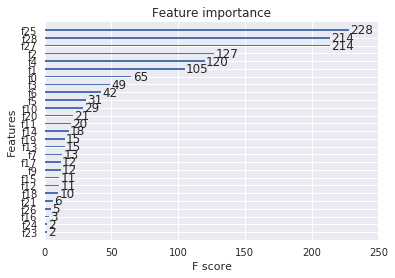

In [171]:
plot_importance(xgb_model,importance_type='weight')

In [174]:
fi = pd.DataFrame(xgb_model.feature_importances_,index=X_train.columns.drop('price'))
fi.reset_index(inplace=True)
fi.columns = ['cols','importance']
fi.sort_values(by= 'importance',inplace=True,ascending=False)



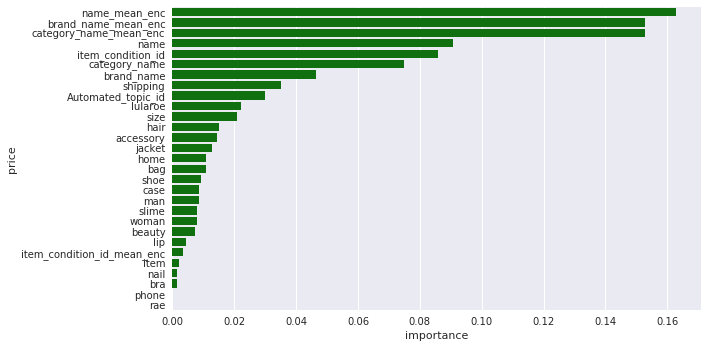

In [181]:
plot_feature_importance(fi)

In [190]:
pdp = partial_dependence(X_train_keep.drop('price',axis=1),'item_condition_id',final_model)

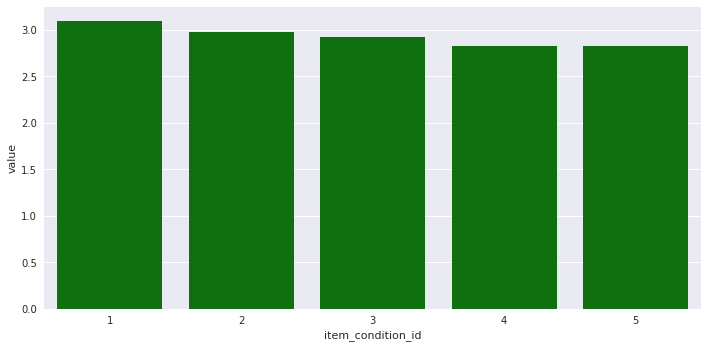

In [191]:
plot_partial_dependence(pdp)